# Lesson 2: Advanced Xarray

In this lesson, we cover some more advanced aspects of xarray.

## Groupby

Xarray copies Pandas' very useful groupby functionality, enabling the "split / apply / combine" workflow on xarray DataArrays and Datasets. In the first part of the lesson, we will learn to use groupby by analyzing sea-surface temperature data.

In [1]:
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

First we load a dataset. We will use the [NOAA Extended Reconstructed Sea Surface Temperature (ERSST) v5](https://www.ncdc.noaa.gov/data-access/marineocean-data/extended-reconstructed-sea-surface-temperature-ersst-v5) product, a widely used and trusted gridded compilation of of historical data going back to 1854.

Since the data is provided via an [OPeNDAP](https://en.wikipedia.org/wiki/OPeNDAP) server, we can load it directly without downloading anything:

In [2]:
url = 'http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/noaa.ersst.v5/sst.mnmean.nc'
ds = xr.open_dataset(url, drop_variables=['time_bnds'])
ds = ds.sel(time=slice('1960', '2018')).load()
ds

<xarray.Dataset>
Dimensions:  (lat: 89, lon: 180, time: 708)
Coordinates:
  * lat      (lat) float32 88.0 86.0 84.0 82.0 80.0 ... -82.0 -84.0 -86.0 -88.0
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * time     (time) datetime64[ns] 1960-01-01 1960-02-01 ... 2018-12-01
Data variables:
    sst      (time, lat, lon) float32 -1.8 -1.8 -1.8 -1.8 ... nan nan nan nan
Attributes:
    climatology:                     Climatology is based on 1971-2000 SST, X...
    description:                     In situ data: ICOADS2.5 before 2007 and ...
    keywords_vocabulary:             NASA Global Change Master Directory (GCM...
    keywords:                        Earth Science > Oceans > Ocean Temperatu...
    instrument:                      Conventional thermometers
    source_comment:                  SSTs were observed by conventional therm...
    geospatial_lon_min:              -1.0
    geospatial_lon_max:              359.0
    geospatial_laty_max:          

Let's do some basic visualizations of the data, just to make sure it looks reasonable.

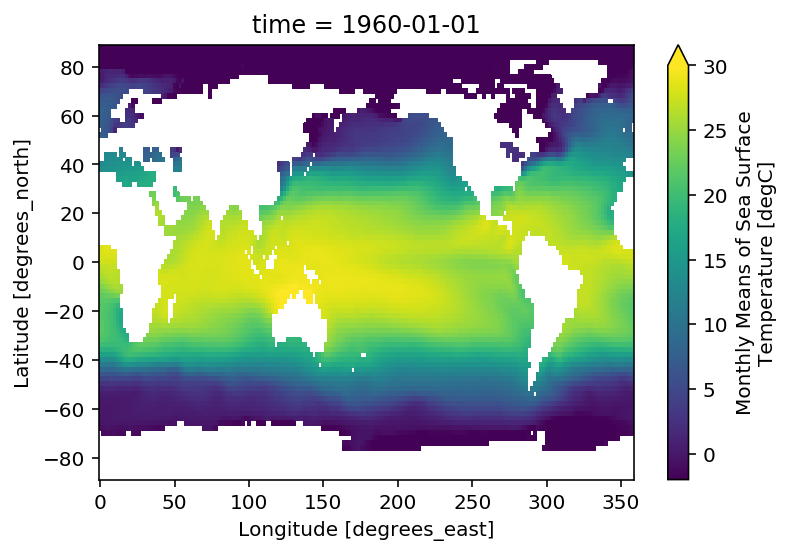

In [3]:
ds.sst[0].plot(vmin=-2, vmax=30)

Note that xarray correctly parsed the time index, resulting in a Pandas datetime index on the time dimension.

In [4]:
ds.time

<xarray.DataArray 'time' (time: 708)>
array(['1960-01-01T00:00:00.000000000', '1960-02-01T00:00:00.000000000',
       '1960-03-01T00:00:00.000000000', ..., '2018-10-01T00:00:00.000000000',
       '2018-11-01T00:00:00.000000000', '2018-12-01T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1960-01-01 1960-02-01 ... 2018-12-01
Attributes:
    long_name:        Time
    delta_t:          0000-01-00 00:00:00
    avg_period:       0000-01-00 00:00:00
    prev_avg_period:  0000-00-07 00:00:00
    standard_name:    time
    axis:             T
    actual_range:     [19723. 80231.]
    _ChunkSizes:      1

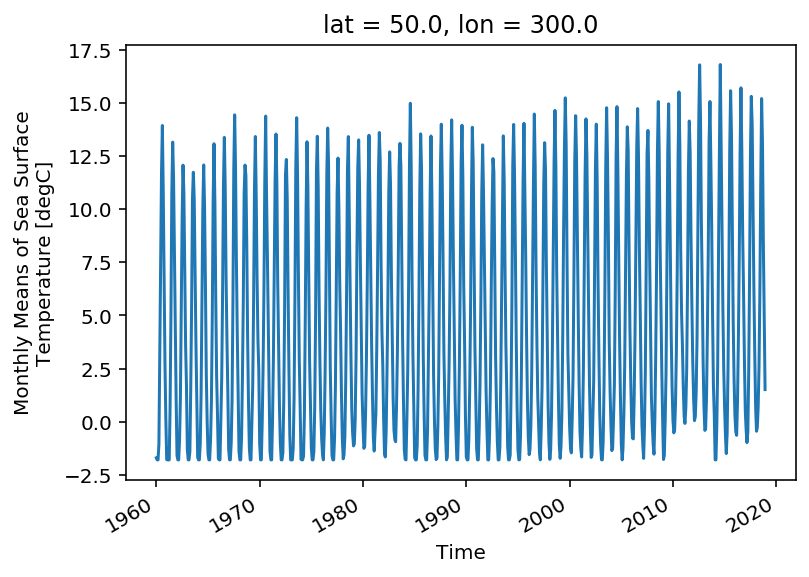

In [5]:
ds.sst.sel(lon=300, lat=50).plot()

As we can see from the plot, the timeseries at any one point is totally dominated by the seasonal cycle. We would like to remove this seasonal cycle (called the "climatology") in order to better see the long-term variaitions in temperature. We will accomplish this using **groupby**.

The syntax of Xarray's groupby is almost identical to Pandas.

In [6]:
ds.groupby?

Signature: ds.groupby(group, squeeze:bool=True, restore_coord_dims:bool=None)
Docstring:
Returns a GroupBy object for performing grouped operations.

Parameters
----------
group : str, DataArray or IndexVariable
    Array whose unique values should be used to group this array. If a
    string, must be the name of a variable contained in this dataset.
squeeze : boolean, optional
    If "group" is a dimension of any arrays in this dataset, `squeeze`
    controls whether the subarrays have a dimension of length 1 along
    that dimension or if the dimension is squeezed out.
restore_coord_dims : bool, optional
    If True, also restore the dimension order of multi-dimensional
    coordinates.

Returns
-------
grouped : GroupBy
    A `GroupBy` object patterned after `pandas.GroupBy` that can be
    iterated over in the form of `(unique_value, grouped_array)` pairs.

Examples
--------
Calculate daily anomalies for daily data:

>>> da = xr.DataArray(np.linspace(0, 1826, num=1827),
...        

### Split Step

The most important argument is `group`: this defines the unique values we will us to "split" the data for grouped analysis. We can pass either a DataArray or a name of a variable in the dataset. Lets first use a DataArray. Just like with Pandas, we can use the time indexe to extract specific components of dates and times. Xarray uses a special syntax for this `.dt`, called the `DatetimeAccessor`.

In [7]:
ds.time.dt

In [8]:
ds.time.dt.month

<xarray.DataArray 'month' (time: 708)>
array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,  1,  2,  3,  4,  5,
        6,  7,  8,  9, 10, 11, 12,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10,
       11, 12,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,  1,  2,  3,
        4,  5,  6,  7,  8,  9, 10, 11, 12,  1,  2,  3,  4,  5,  6,  7,  8,
        9, 10, 11, 12,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,  1,
        2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,  1,  2,  3,  4,  5,  6,
        7,  8,  9, 10, 11, 12,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11,
       12,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,  1,  2,  3,  4,
        5,  6,  7,  8,  9, 10, 11, 12,  1,  2,  3,  4,  5,  6,  7,  8,  9,
       10, 11, 12,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,  1,  2,
        3,  4,  5,  6,  7,  8,  9, 10, 11, 12,  1,  2,  3,  4,  5,  6,  7,
        8,  9, 10, 11, 12,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,
        1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,  1,  2

ds.time.dt.year

We can use these arrays in a groupby operation:

In [9]:
gb = ds.groupby(ds.time.dt.month)
gb

Xarray also offers a more concise syntax when the variable you're grouping on is already present in the dataset. This is identical to the previous line:

In [10]:
gb = ds.groupby('time.month')
gb

Now that the data are split, we can manually iterate over the group. The iterator returns the key (group name) and the value (the actual dataset corresponding to that group) for each group.

In [11]:
for group_name, group_ds in gb:
    # stop iterating after the first loop
    break 
print(group_name)
group_ds

1


<xarray.Dataset>
Dimensions:  (lat: 89, lon: 180, time: 59)
Coordinates:
  * lat      (lat) float32 88.0 86.0 84.0 82.0 80.0 ... -82.0 -84.0 -86.0 -88.0
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * time     (time) datetime64[ns] 1960-01-01 1961-01-01 ... 2018-01-01
Data variables:
    sst      (time, lat, lon) float32 -1.8 -1.8 -1.8 -1.8 ... nan nan nan nan
Attributes:
    climatology:                     Climatology is based on 1971-2000 SST, X...
    description:                     In situ data: ICOADS2.5 before 2007 and ...
    keywords_vocabulary:             NASA Global Change Master Directory (GCM...
    keywords:                        Earth Science > Oceans > Ocean Temperatu...
    instrument:                      Conventional thermometers
    source_comment:                  SSTs were observed by conventional therm...
    geospatial_lon_min:              -1.0
    geospatial_lon_max:              359.0
    geospatial_laty_max:           

### Apply & Combine

Now that we have groups defined, it's time to "apply" a calculation to the group. Like in Pandas, these calculations can either be:
- _aggregation_: reduces the size of the group
- _transformation_: preserves the group's full size

At then end of the apply step, xarray will automatically combine the aggregated / transformed groups back into a single object.

The most fundamental way to apply is with the `.apply` method.

In [12]:
gb.apply?

Signature: gb.apply(func, args=(), shortcut=None, **kwargs)
Docstring:
Apply a function over each Dataset in the group and concatenate them
together into a new Dataset.

`func` is called like `func(ds, *args, **kwargs)` for each dataset `ds`
in this group.

Apply uses heuristics (like `pandas.GroupBy.apply`) to figure out how
to stack together the datasets. The rule is:

1. If the dimension along which the group coordinate is defined is
   still in the first grouped item after applying `func`, then stack
   over this dimension.
2. Otherwise, stack over the new dimension given by name of this
   grouping (the argument to the `groupby` function).

Parameters
----------
func : function
    Callable to apply to each sub-dataset.
args : tuple, optional
    Positional arguments to pass to `func`.
**kwargs
    Used to call `func(ds, **kwargs)` for each sub-dataset `ar`.

Returns
-------
applied : Dataset or DataArray
    The result of splitting, applying and combining this dataset.
File:     

#### Aggregations

`.apply` accepts as its argument a function. We can pass an existing function:

In [13]:
gb.apply(np.mean)

<xarray.Dataset>
Dimensions:  (month: 12)
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    sst      (month) float32 13.659287 13.768365 ... 13.506346 13.529349

Because we specified no extra arguments (like `axis`) the function was applied over all space and time dimensions. This is not what we wanted. Instead, we could define a custom function. This function takes a single argument--the group dataset--and returns a new dataset to be combined:

In [14]:
def time_mean(a):
    return a.mean(dim='time')

gb.apply(time_mean)

/Users/rpa/miniconda3/envs/pangeo/lib/python3.6/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


<xarray.Dataset>
Dimensions:  (lat: 89, lon: 180, month: 12)
Coordinates:
  * lat      (lat) float32 88.0 86.0 84.0 82.0 80.0 ... -82.0 -84.0 -86.0 -88.0
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    sst      (month, lat, lon) float32 -1.8000009 -1.8000009 ... nan nan

Like Pandas, xarray's groupby object has many built-in aggregation operations (e.g. `mean`, `min`, `max`, `std`, etc):

In [15]:
# this does the same thing as the previous cell
ds_mm = gb.mean(dim='time')
ds_mm

<xarray.Dataset>
Dimensions:  (lat: 89, lon: 180, month: 12)
Coordinates:
  * lat      (lat) float32 88.0 86.0 84.0 82.0 80.0 ... -82.0 -84.0 -86.0 -88.0
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    sst      (month, lat, lon) float32 -1.8000009 -1.8000009 ... nan nan

So we did what we wanted to do: calculate the climatology at every point in the dataset. Let's look at the data a bit.

_Climatlogy at a specific point in the North Atlantic_

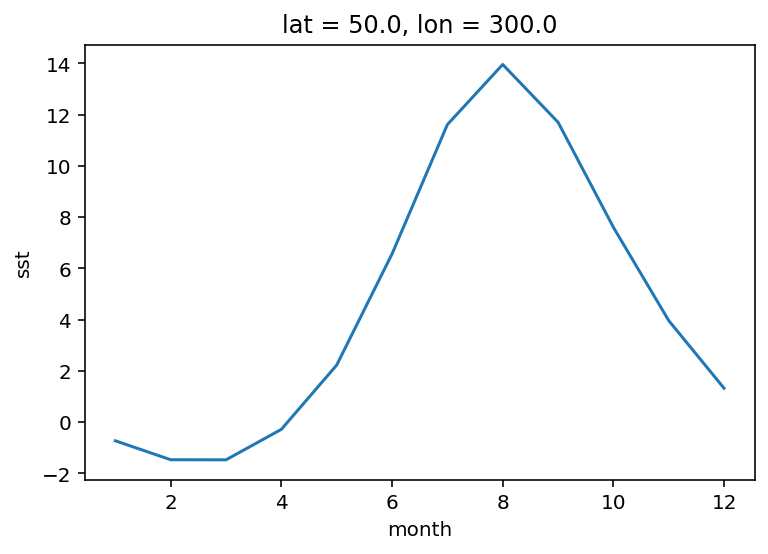

In [16]:
ds_mm.sst.sel(lon=300, lat=50).plot()

_Zonal Mean Climatolgoy_

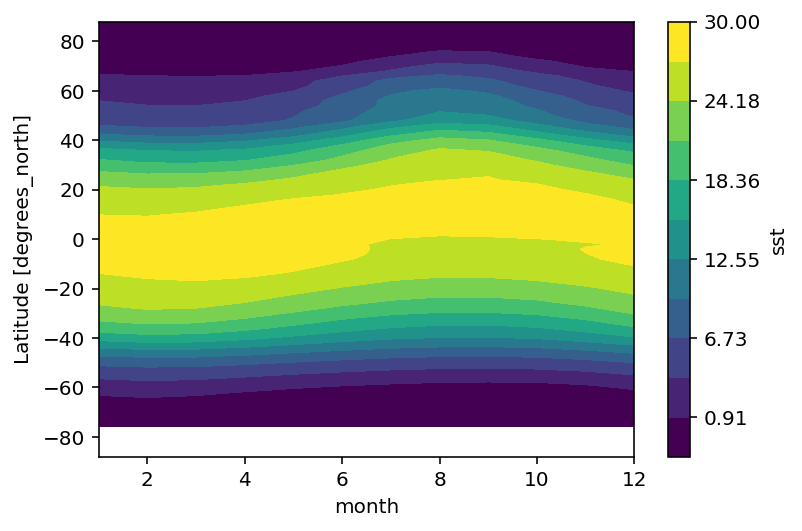

In [17]:
ds_mm.sst.mean(dim='lon').transpose().plot.contourf(levels=12, vmin=-2, vmax=30)

_Difference between January and July Climatology_

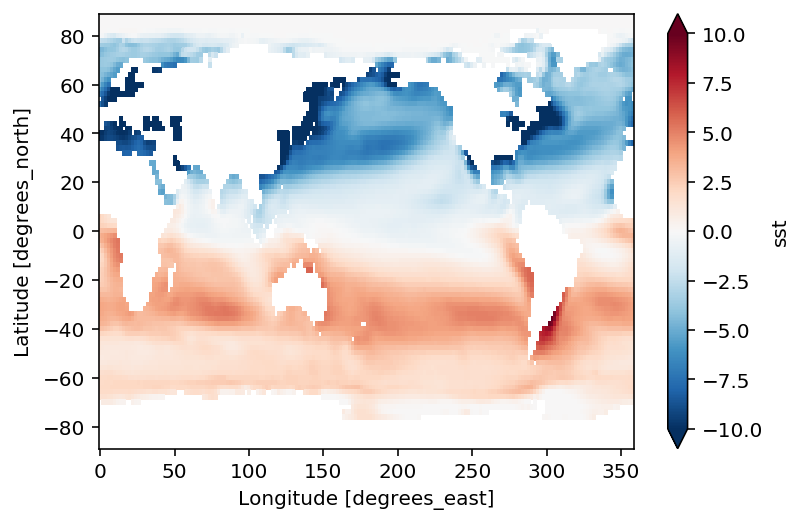

In [18]:
(ds_mm.sst.sel(month=1) - ds_mm.sst.sel(month=7)).plot(vmax=10)

#### Transformations

Now we want to _remove_ this climatology from the dataset, to examine the residual, called the _anomaly_, which is the interesting part from a climate perspective.
Removing the seasonal climatology is a perfect example of a transformation: it operates over a group, but doesn't change the size of the dataset. Here is one way to code it

In [19]:
def remove_time_mean(x):
    return x - x.mean(dim='time')

ds_anom = ds.groupby('time.month').apply(remove_time_mean)
ds_anom

/Users/rpa/miniconda3/envs/pangeo/lib/python3.6/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


<xarray.Dataset>
Dimensions:  (lat: 89, lon: 180, time: 708)
Coordinates:
  * lat      (lat) float32 88.0 86.0 84.0 82.0 80.0 ... -82.0 -84.0 -86.0 -88.0
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * time     (time) datetime64[ns] 1960-01-01 1960-02-01 ... 2018-12-01
Data variables:
    sst      (time, lat, lon) float32 9.536743e-07 9.536743e-07 ... nan nan
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12

Xarray makes these sorts of transformations easy by supporting _groupby arithmetic_.
This concept is easiest explained with an example:

In [20]:
gb = ds.groupby('time.month')
ds_anom = gb - gb.mean(dim='time')
ds_anom

/Users/rpa/miniconda3/envs/pangeo/lib/python3.6/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


<xarray.Dataset>
Dimensions:  (lat: 89, lon: 180, time: 708)
Coordinates:
  * lat      (lat) float32 88.0 86.0 84.0 82.0 80.0 ... -82.0 -84.0 -86.0 -88.0
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * time     (time) datetime64[ns] 1960-01-01 1960-02-01 ... 2018-12-01
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    sst      (time, lat, lon) float32 9.536743e-07 9.536743e-07 ... nan nan

Now we can view the climate signal without the overwhelming influence of the seasonal cycle.

_Timeseries at a single point in the North Atlantic_

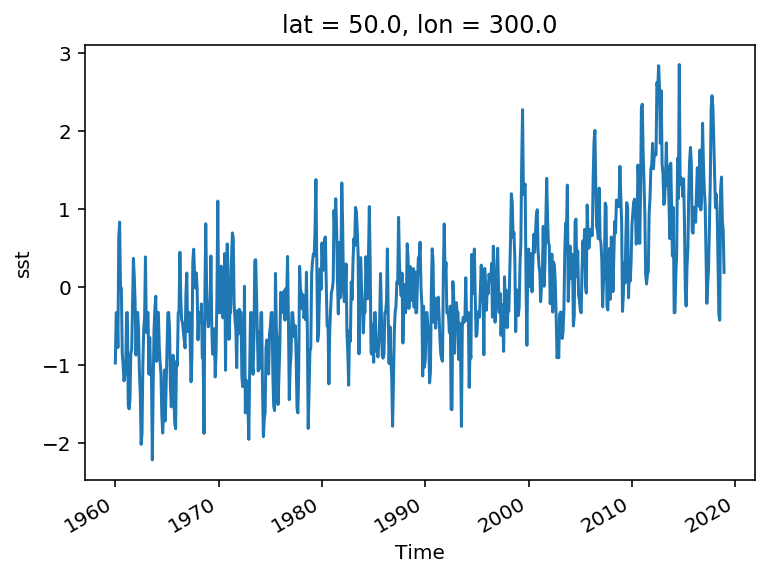

In [21]:
ds_anom.sst.sel(lon=300, lat=50).plot()

_Difference between Jan. 1 2018 and Jan. 1 1960_

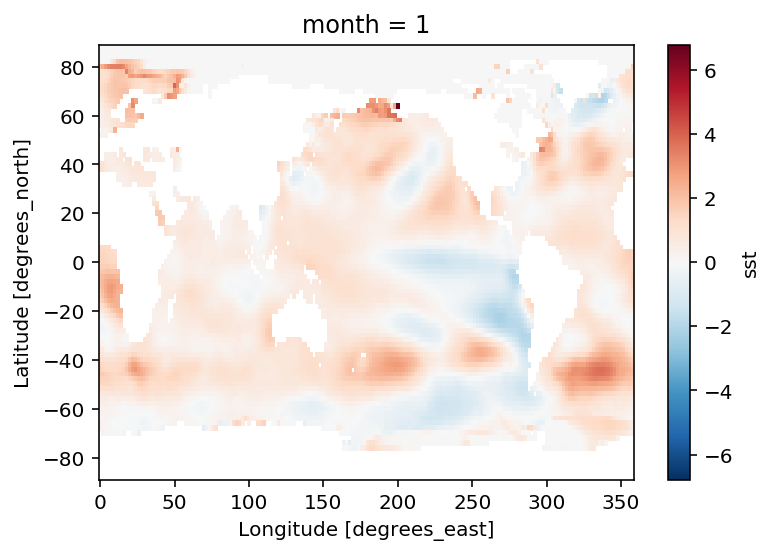

In [22]:
(ds_anom.sel(time='2018-01-01') - ds_anom.sel(time='1960-01-01')).sst.plot()

## Grouby-Related: Resample, Rolling, Coarsen

Resample in xarray is nearly identical to Pandas. It is effectively a group-by operation, and uses the same basic syntax. It can be applied only to time-index dimensions. Here we compute the five-year mean.

In [23]:
ds_anom_resample = ds_anom.resample(time='5Y').mean(dim='time')
ds_anom_resample

/Users/rpa/miniconda3/envs/pangeo/lib/python3.6/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


<xarray.Dataset>
Dimensions:  (lat: 89, lon: 180, time: 13)
Coordinates:
  * time     (time) datetime64[ns] 1960-12-31 1965-12-31 ... 2020-12-31
  * lat      (lat) float32 88.0 86.0 84.0 82.0 80.0 ... -82.0 -84.0 -86.0 -88.0
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
Data variables:
    sst      (time, lat, lon) float32 -0.00049557287 -0.00048864883 ... nan nan

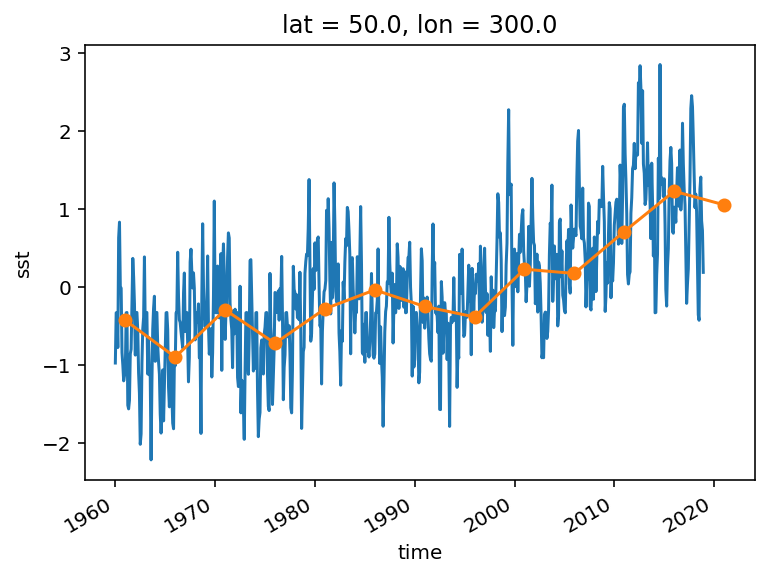

In [24]:
ds_anom.sst.sel(lon=300, lat=50).plot()
ds_anom_resample.sst.sel(lon=300, lat=50).plot(marker='o')

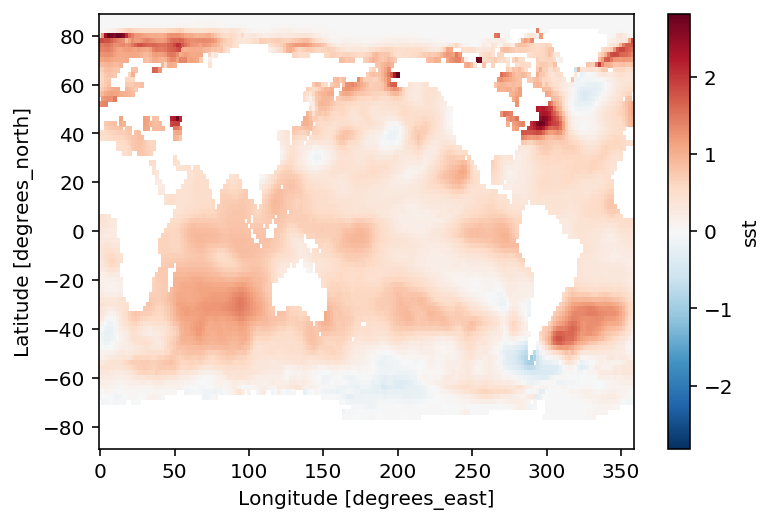

In [25]:
(ds_anom_resample.sel(time='2015-01-01', method='nearest') -
 ds_anom_resample.sel(time='1965-01-01', method='nearest')).sst.plot()

Rolling is also similar to pandas.

In [26]:
ds_anom_rolling = ds_anom.rolling(time=12, center=True).mean()
ds_anom_rolling

<xarray.Dataset>
Dimensions:  (lat: 89, lon: 180, time: 708)
Coordinates:
  * lat      (lat) float32 88.0 86.0 84.0 82.0 80.0 ... -82.0 -84.0 -86.0 -88.0
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * time     (time) datetime64[ns] 1960-01-01 1960-02-01 ... 2018-12-01
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    sst      (time, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan

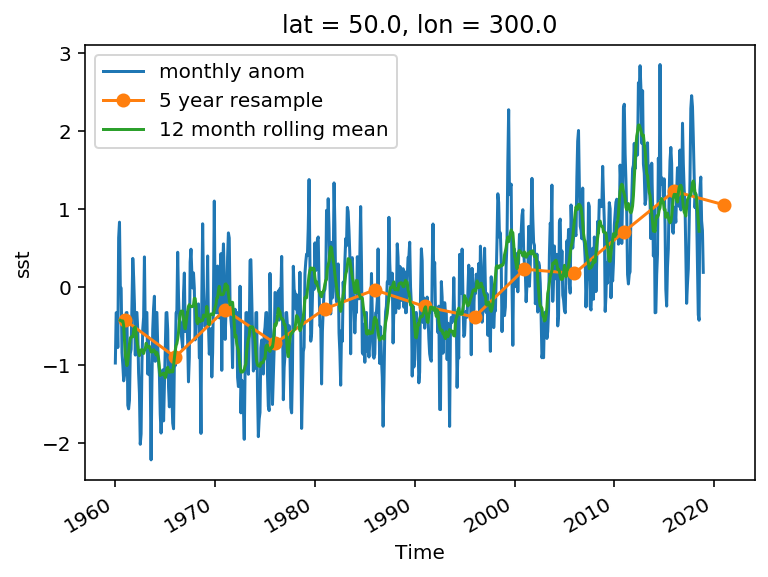

In [27]:
ds_anom.sst.sel(lon=300, lat=50).plot(label='monthly anom')
ds_anom_resample.sst.sel(lon=300, lat=50).plot(marker='o', label='5 year resample')
ds_anom_rolling.sst.sel(lon=300, lat=50).plot(label='12 month rolling mean')
plt.legend()

In [28]:
basin = xr.open_dataset('http://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NODC/.WOA09/.Masks/.basin/dods')
basin

<xarray.Dataset>
Dimensions:  (X: 360, Y: 180, Z: 33)
Coordinates:
  * Z        (Z) float32 0.0 10.0 20.0 30.0 50.0 ... 4000.0 4500.0 5000.0 5500.0
  * X        (X) float32 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
  * Y        (Y) float32 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
Data variables:
    basin    (Z, Y, X) float32 ...
Attributes:
    Conventions:  IRIDL

In [29]:
basin = basin.rename({'X': 'lon', 'Y': 'lat'})
basin

<xarray.Dataset>
Dimensions:  (Z: 33, lat: 180, lon: 360)
Coordinates:
  * Z        (Z) float32 0.0 10.0 20.0 30.0 50.0 ... 4000.0 4500.0 5000.0 5500.0
  * lon      (lon) float32 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
  * lat      (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
Data variables:
    basin    (Z, lat, lon) float32 ...
Attributes:
    Conventions:  IRIDL

In [30]:
basin_surf = basin.basin[0]
basin_surf

<xarray.DataArray 'basin' (lat: 180, lon: 360)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [11., 11., 11., ..., 11., 11., 11.],
       [11., 11., 11., ..., 11., 11., 11.],
       [11., 11., 11., ..., 11., 11., 11.]], dtype=float32)
Coordinates:
    Z        float32 0.0
  * lon      (lon) float32 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
  * lat      (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
Attributes:
    long_name:  basin code
    scale_min:  1
    units:      ids
    scale_max:  58
    CLIST:      Atlantic Ocean\nPacific Ocean \nIndian Ocean\nMediterranean S...
    valid_min:  1
    valid_max:  58

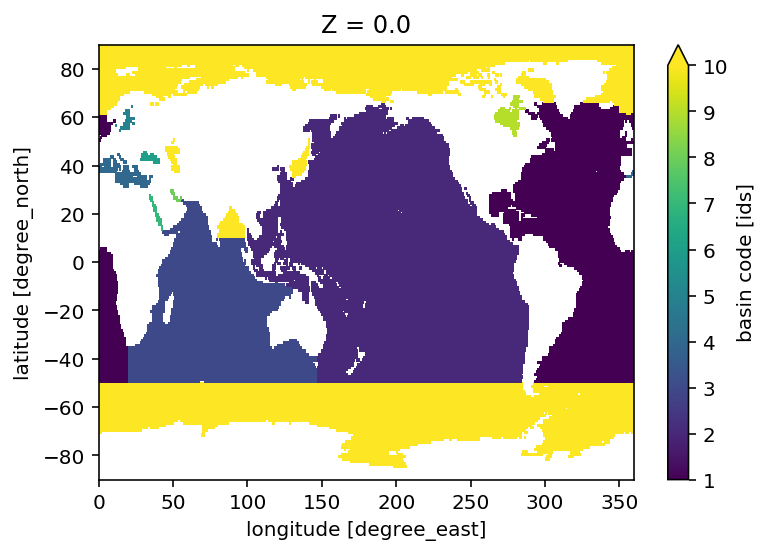

In [31]:
basin_surf.plot(vmax=10)

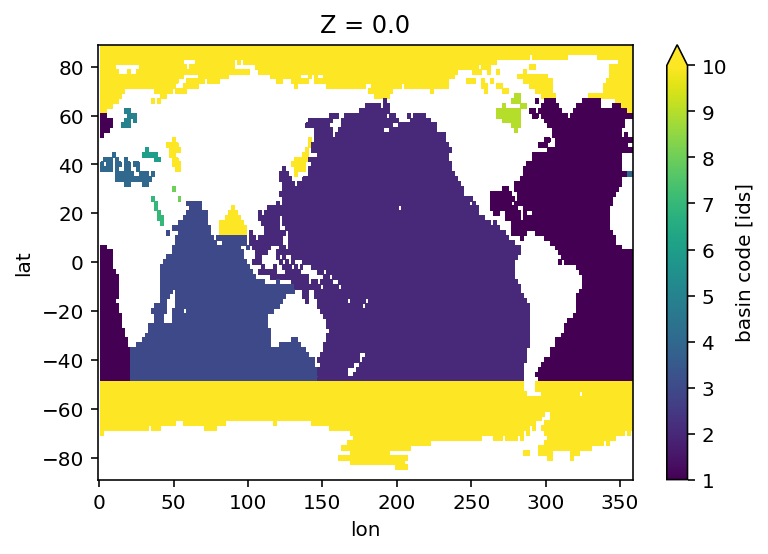

In [32]:
basin_surf_interp = basin_surf.interp_like(ds.sst, method='nearest')
basin_surf_interp.plot(vmax=10)

In [33]:
ds.sst.groupby(basin_surf_interp).first()

<xarray.DataArray 'sst' (time: 708, basin: 14)>
array([[-1.8000000e+00, -1.8000000e+00,  2.3455315e+01, ...,
        -1.8000000e+00,  3.3971915e+00,  2.4182198e+01],
       [-1.8000000e+00, -1.8000000e+00,  2.3722523e+01, ...,
        -1.8000000e+00,  3.5737813e-02,  2.4596569e+01],
       [-1.8000000e+00, -1.8000000e+00,  2.4601315e+01, ...,
        -1.8000000e+00, -2.6487017e-01,  2.6234186e+01],
       ...,
       [ 7.6797301e-01,  6.2722030e+00,  2.9107103e+01, ...,
         1.0974343e+01,  1.6757624e+01,  2.9398691e+01],
       [-6.5389156e-01,  3.1594794e+00,  2.7567032e+01, ...,
         5.6752982e+00,  1.1600289e+01,  2.7634481e+01],
       [-1.8000000e+00,  1.6197562e-02,  2.5841175e+01, ...,
         1.0407574e+00,  7.7793398e+00,  2.6097622e+01]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1960-01-01 1960-02-01 ... 2018-12-01
  * basin    (basin) float64 1.0 2.0 3.0 4.0 5.0 ... 10.0 11.0 12.0 53.0 56.0
Attributes:
    long_name:     Monthly Means of Sea S

In [34]:
basin_mean_sst = ds_mm.sst.groupby(basin_surf_interp).mean()
basin_mean_sst

<xarray.DataArray 'sst' (basin: 14)>
array([19.285284  , 21.178099  , 21.127298  , 19.844341  ,  8.137447  ,
       15.087128  , 28.50029   , 26.615328  ,  0.30564737,  1.5446833 ,
       -0.8181379 , 12.091027  , 14.318968  , 28.462448  ], dtype=float32)
Coordinates:
  * basin    (basin) float64 1.0 2.0 3.0 4.0 5.0 ... 10.0 11.0 12.0 53.0 56.0

In [35]:
df = basin_mean_sst.to_dataframe()
df

,sst
basin,
1.0,19.285284
2.0,21.178099
3.0,21.127298
4.0,19.844341
5.0,8.137447
6.0,15.087128
7.0,28.500290
8.0,26.615328
9.0,0.305647


In [36]:
import pandas as pd
import numpy as np
basin_names = basin_surf.attrs['CLIST'].split('\n')
basin_df = pd.Series(basin_names, index=np.arange(1, len(basin_names)+1))
basin_df

1                 Atlantic Ocean
2                 Pacific Ocean 
3                   Indian Ocean
4              Mediterranean Sea
5                     Baltic Sea
6                      Black Sea
7                        Red Sea
8                   Persian Gulf
9                     Hudson Bay
10                Southern Ocean
11                  Arctic Ocean
12                  Sea of Japan
13                      Kara Sea
14                      Sulu Sea
15                    Baffin Bay
16            East Mediterranean
17            West Mediterranean
18                Sea of Okhotsk
19                     Banda Sea
20                 Caribbean Sea
21                 Andaman Basin
22               North Caribbean
23                Gulf of Mexico
24                  Beaufort Sea
25               South China Sea
26                   Barents Sea
27                   Celebes Sea
28                Aleutian Basin
29                    Fiji Basin
30          North American Basin
31        

In [37]:
df = df.join(basin_df.rename('basin_name'))

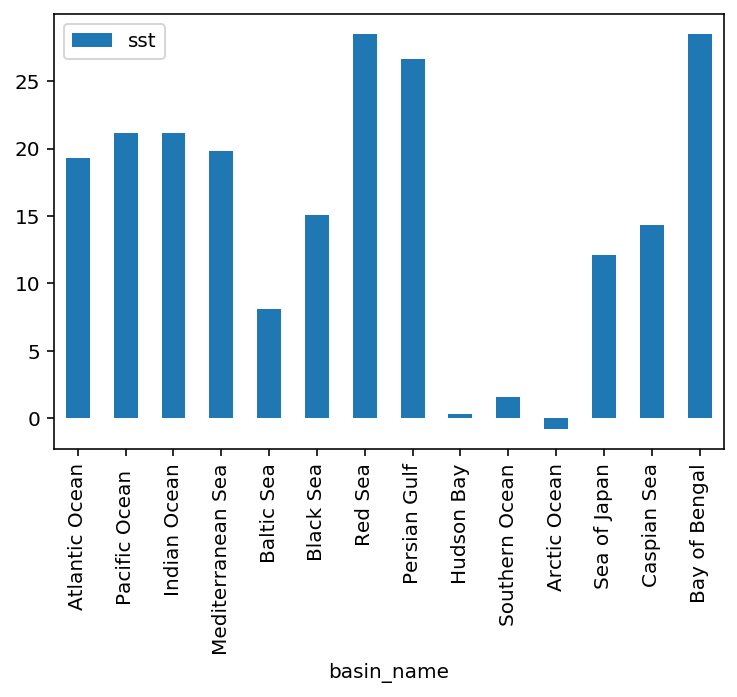

In [38]:
df.plot.bar(x='basin_name')